In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images


100% 1.14G/1.14G [00:17<00:00, 81.9MB/s]
100% 1.14G/1.14G [00:17<00:00, 68.3MB/s]


In [ ]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/data"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.
{0: 1.9371534195933457, 1: 0.6739549839228296}
Epoch 1/25
262/262 [==============================] - 88s 285ms/step - loss: 0.6028 - accuracy: 0.6240 - val_loss: 0.2140 - val_accuracy: 0.9327 - lr: 0.0010
Epoch 2/25
262/262 [==============================] - 76s 290ms/step - loss: 0.3222 - accuracy: 0.8552 - val_loss: 0.5429 - val_accuracy: 0.9087 - lr: 0.0010
Epoch 3/25
262/262 [==============================] - ETA: 0s - loss: 0.2804 - accuracy: 0.8819
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
262/262 [==============================] - 76s 291ms/step - loss: 0.2804 - accuracy: 0.8819 - val_loss: 0.2346 - val_accuracy: 0.9058 - lr: 0.0010
Epoch 4/25
262/262 [==============================] - 77s 294ms/step - loss: 0.2330 - accuracy: 0.9031 - val_loss: 0.1588 - val_accuracy: 0.9538 - lr: 5.0000e-04
Epoch 5/25
262/262 [=======

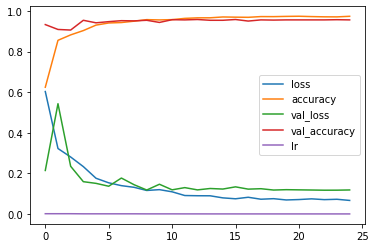

39/39 [==============================] - 5s 134ms/step - loss: 0.3349 - accuracy: 0.9199
The testing accuracy is : 91.98718070983887 %


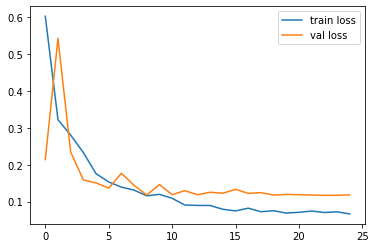

39/39 [==============================] - 5s 133ms/step


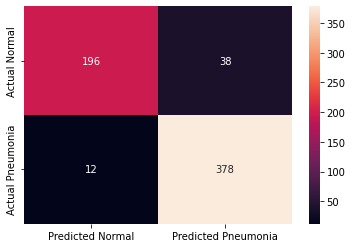

              precision    recall  f1-score   support

      NORMAL       0.94      0.84      0.89       234
   PNEUMONIA       0.91      0.97      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624

Precision : 0.9254807692307692
Recall    : 0.9034188034188034
F1-score  : 0.9124215443001022


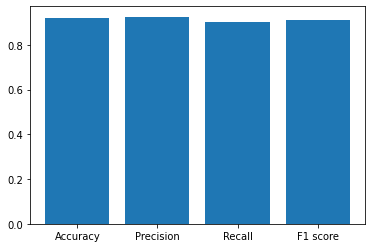

In [ ]:
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,BatchNormalization,Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential,load_model,save_model
from sklearn.metrics import precision_recall_fscore_support as score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time


train_path = "data/train"
test_path = "data/test"
valid_path = "data/val"

batch_size = 16
img_height = 250
img_width = 250

loader = ImageDataGenerator(rescale = 1./255,)
loader2 = ImageDataGenerator(rescale = 1./255,)
train_loader = ImageDataGenerator(rescale = 1./255, horizontal_flip=True, shear_range = 0.2, zoom_range = 0.2)

train = train_loader.flow_from_directory(
	train_path,
  color_mode='grayscale',
	target_size=(img_height, img_width),
	class_mode='binary',
	batch_size=batch_size)

test = loader.flow_from_directory(
	test_path,
  shuffle=False,
  color_mode='grayscale',
	target_size=(img_height, img_width),
	class_mode='binary',
	batch_size=batch_size)

valid = loader2.flow_from_directory(
	valid_path,
  color_mode='grayscale',
	target_size=(img_height, img_width),
	class_mode='binary',
	batch_size=batch_size)

cnn = Sequential()

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1), padding="same"))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(256, (3, 3), activation="relu", padding="same"))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 512))
cnn.add(Dense(activation = 'relu', units = 256))
cnn.add(Dense(activation = 'sigmoid', units = 1))

cnn.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['accuracy'])

early = EarlyStopping(monitor="val_loss", mode="min", patience=4)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.5, min_lr=0.000001)

callbacks_list = [learning_rate_reduction]

weights = compute_class_weight('balanced', classes=np.unique(train.classes), y=train.classes)
cw = dict(zip(np.unique(train.classes), weights))
print(cw)

start = time.time()

cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list, shuffle=True)

end = time.time()
print()
print()
print("Train time:")
print(end - start)
print()
print()

data = pd.DataFrame(cnn.history.history)

data.plot()
plt.show()

test_accu = cnn.evaluate(test)

print('The testing accuracy is :',test_accu[1]*100, '%')

plt.plot(data['loss'], label='train loss')
plt.plot(data['val_loss'], label='val loss')
plt.legend()
plt.show()

preds = cnn.predict(test,verbose=1)

predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])

sns.heatmap(cm,annot=True,fmt="d")
plt.show()

print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

precision,recall,f1_score,support=score(test.classes,predictions,average='macro')

print ('Precision : {}'.format(precision))
print ('Recall    : {}'.format(recall))
print ('F1-score  : {}'.format(f1_score))

stats = ["Accuracy", "Precision", "Recall", "F1 score"]
values = [test_accu[1], precision, recall, f1_score]

plt.bar(stats, values)
plt.show()

cnn.save("model.h5")